ID: 2114951040

**Project Name: Classification of Conditions Using Gene Expression**

In [ ]:
#pip install pandas scikit-learn seaborn matplotlib

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#dataset Path
file_path = '/content/drive/MyDrive/BioProject_Final/GSE276122_FPKMtable.csv'

In [4]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/BioProject_Final/GSE276122_FPKMtable.csv')

In [5]:
# Get the column names
column_names = data.columns
# Print the column names
print("Column Names:")
print(column_names)

Column Names:
Index(['Unnamed: 0', 'gene_id', 'gene_name', 'description', 'locus',
       'CTR_FPKM', 'DSF_FPKM', 'IM_FPKM', 'IM.DSF_FPKM'],
      dtype='object')


In [6]:
# Extract features and labels
features = data[['CTR_FPKM', 'DSF_FPKM', 'IM_FPKM', 'IM.DSF_FPKM']]
labels = ['CTR', 'DSF', 'IM', 'IM.DSF']  # Example condition labels


In [7]:
# Convert dataset from wide to long format for analysis
data_long = data.melt(
    id_vars=['gene_id', 'gene_name', 'description', 'locus'],
    value_vars=['CTR_FPKM', 'DSF_FPKM', 'IM_FPKM', 'IM.DSF_FPKM'],
    var_name='condition',
    value_name='expression'
)

# Extract condition names from column names
data_long['condition'] = data_long['condition'].str.replace('_FPKM', '')

print(data_long.head())

           gene_id   gene_name  \
0  ENSG00000282222  AC073488.4   
1  ENSG00000282221  AC119427.1   
2  ENSG00000110514        MADD   
3  ENSG00000086015       MAST2   
4  ENSG00000250337       PURPL   

                                         description                  locus  \
0  chromodomain protein, Y chromosome-like (CDYL)...      X:9410789-9411545   
1                novel transcript, antisense to LAD1  1:201399633-201401190   
2  MAP kinase activating death domain [Source:HGN...   11:47269161-47330031   
3  microtubule associated serine/threonine kinase...    1:45786987-46036124   
4  p53 upregulated regulator of p53 levels [Sourc...    5:27472292-27496401   

  condition  expression  
0       CTR    0.000000  
1       CTR    0.000000  
2       CTR    7.748822  
3       CTR    2.968436  
4       CTR    0.000000  


In [9]:
# Features: Expression values
features = data[['CTR_FPKM', 'DSF_FPKM', 'IM_FPKM', 'IM.DSF_FPKM']]

# Labels: The condition with maximum expression for classification
data['condition'] = features.idxmax(axis=1).str.replace('_FPKM', '')

# Encoding labels for machine learning
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['condition_encoded'] = label_encoder.fit_transform(data['condition'])

# Splitting the data into train and test sets
from sklearn.model_selection import train_test_split
X = features
y = data['condition_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (40694, 4)
Test set size: (10174, 4)


In [10]:
from sklearn.feature_selection import f_classif

# Perform ANOVA to assess feature importance
f_values, p_values = f_classif(X_train, y_train)

# Create a DataFrame of results
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'F-value': f_values,
    'P-value': p_values
}).sort_values(by='F-value', ascending=False)

print(feature_importance)

       Feature    F-value       P-value
2      IM_FPKM  28.154685  3.529885e-18
1     DSF_FPKM  26.413043  4.640338e-17
3  IM.DSF_FPKM  25.657745  1.417449e-16
0     CTR_FPKM  24.721154  5.657919e-16


In [11]:
significant_features = feature_importance[feature_importance['P-value'] < 0.05]['Feature']
X_train = X_train[significant_features]
X_test = X_test[significant_features]

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("Model trained successfully!")

Model trained successfully!


Accuracy: 0.9765087477884804
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6748
           1       0.95      0.90      0.93       818
           2       0.95      0.92      0.94      1059
           3       0.95      0.98      0.96      1549

    accuracy                           0.98     10174
   macro avg       0.96      0.95      0.95     10174
weighted avg       0.98      0.98      0.98     10174



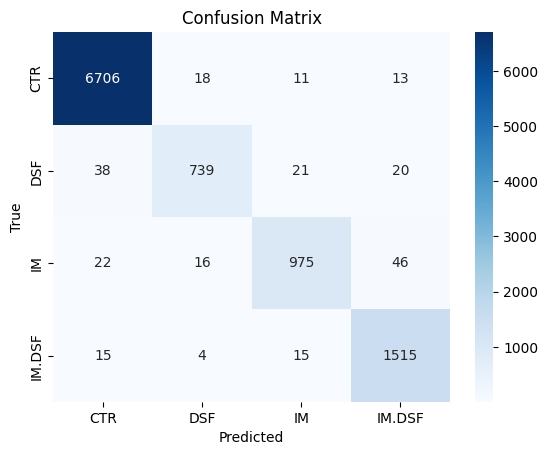

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

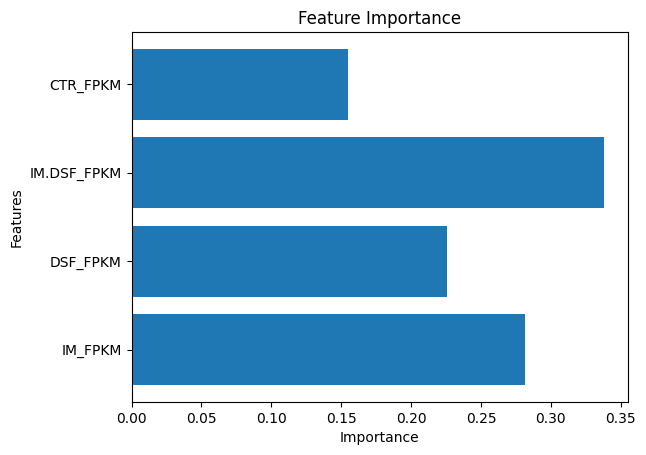

In [14]:
# Feature Importance Plot
import numpy as np
plt.barh(np.array(significant_features), model.feature_importances_)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

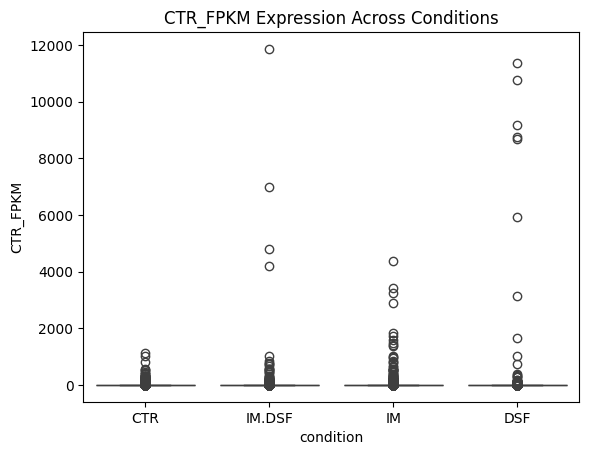

In [ ]:
# Expression Distribution Visualization
sns.boxplot(data=data, x='condition', y='CTR_FPKM')
plt.title("CTR_FPKM Expression Across Conditions")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to test
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7fa166e110>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7fa166e200>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c7fa121bbe0>},
                   scoring='accuracy', verbose=2)

D**ata Preprocessing: Preparing dataset for training:**

In [22]:

print("First 5 rows of the dataset:")
print(data.head())

data = data.dropna()

features = data[['CTR_FPKM', 'DSF_FPKM', 'IM_FPKM', 'IM.DSF_FPKM']]
labels = features.idxmax(axis=1).str.replace('_FPKM', '')


label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    normalized_features, encoded_labels, test_size=0.2, random_state=42
)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Labels Shape:", len(y_train))
print("Testing Labels Shape:", len(y_test))


First 5 rows of the dataset:
   Unnamed: 0          gene_id   gene_name  \
0           1  ENSG00000282222  AC073488.4   
1           2  ENSG00000282221  AC119427.1   
2           3  ENSG00000110514        MADD   
3           4  ENSG00000086015       MAST2   
4           5  ENSG00000250337       PURPL   

                                         description                  locus  \
0  chromodomain protein, Y chromosome-like (CDYL)...      X:9410789-9411545   
1                novel transcript, antisense to LAD1  1:201399633-201401190   
2  MAP kinase activating death domain [Source:HGN...   11:47269161-47330031   
3  microtubule associated serine/threonine kinase...    1:45786987-46036124   
4  p53 upregulated regulator of p53 levels [Sourc...    5:27472292-27496401   

   CTR_FPKM  DSF_FPKM   IM_FPKM  IM.DSF_FPKM  
0  0.000000  0.000000  0.000000     0.000000  
1  0.000000  0.000000  0.000000     0.000000  
2  7.748822  8.165853  7.929854     8.319758  
3  2.968436  3.281607  3.012376